In [1]:
# Import libraries
from joblib import dump
import scikitplot as skplt
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:

df_official = pd.read_csv('../cleaned_data_KSI.csv')
df_official.info()

print(df_official.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17522 entries, 0 to 17521
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LATITUDE       17522 non-null  float64
 1   LONGITUDE      17522 non-null  float64
 2   ACCLOC         12514 non-null  object 
 3   VISIBILITY     17522 non-null  object 
 4   LIGHT          17522 non-null  object 
 5   RDSFCOND       17522 non-null  object 
 6   ACCLASS        17522 non-null  object 
 7   IMPACTYPE      17522 non-null  object 
 8   INVTYPE        17522 non-null  object 
 9   INVAGE         17522 non-null  object 
 10  INJURY         9269 non-null   object 
 11  DRIVCOND       8935 non-null   object 
 12  PEDESTRIAN     17522 non-null  int64  
 13  CYCLIST        17522 non-null  int64  
 14  AUTOMOBILE     17522 non-null  int64  
 15  MOTORCYCLE     17522 non-null  int64  
 16  TRUCK          17522 non-null  int64  
 17  TRSN_CITY_VEH  17522 non-null  int64  
 18  EMERG_

In [3]:
df_official

,LATITUDE,LONGITUDE,ACCLOC,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,...,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,HOOD_158,HOOD_140
0,43.656345,-79.452490,At Intersection,Clear,Daylight,Dry,Fatal,Pedestrian Collisions,Driver,unknown,...,0,0,NaN,0,1,0,0,0,88.0,88.0
1,43.656345,-79.452490,At Intersection,Clear,Daylight,Dry,Fatal,Pedestrian Collisions,Pedestrian,65 to 69,...,0,0,NaN,0,1,0,0,0,88.0,88.0
2,43.801943,-79.199786,At Intersection,Clear,Daylight,Dry,Fatal,Turning Movement,Motorcycle Driver,45 to 49,...,0,0,NaN,0,1,1,0,0,146.0,132.0
3,43.699595,-79.318797,Intersection Related,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,50 to 54,...,0,0,Yes,1,1,0,1,0,60.0,60.0
4,43.801943,-79.199786,At Intersection,Clear,Daylight,Dry,Fatal,Turning Movement,Driver,unknown,...,0,0,NaN,0,1,1,0,0,146.0,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17517,43.696864,-79.436534,At Intersection,Clear,Dark,Wet,Non-Fatal Injury,Pedestrian Collisions,Pedestrian,5 to 9,...,0,0,NaN,0,1,0,0,0,106.0,106.0
17518,43.696864,-79.436534,At Intersection,Clear,Dark,Wet,Non-Fatal Injury,Pedestrian Collisions,Pedestrian,0 to 4,...,0,0,NaN,0,1,0,0,0,106.0,106.0
17519,43.696864,-79.436534,At Intersection,Clear,Dark,Wet,Non-Fatal Injury,Pedestrian Collisions,Pedestrian,0 to 4,...,0,0,NaN,0,1,0,0,0,106.0,106.0
17520,43.662856,-79.421268,Non Intersection,Rain,"Dark, artificial",Wet,Non-Fatal Injury,Pedestrian Collisions,Driver,35 to 39,...,0,0,NaN,0,0,0,0,0,80.0,80.0


In [4]:
x_group3 = df_official.drop(columns=['ACCLASS'], axis=1)
y_group3 = df_official['ACCLASS']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in sss.split(x_group3, y_group3):
    x_train, x_test = x_group3.loc[train_index], x_group3.loc[test_index]
    y_train, y_test = y_group3.loc[train_index], y_group3.loc[test_index]

print("Before using SMOTE")
print(y_train.value_counts())

Before using SMOTE
ACCLASS
Non-Fatal Injury    10564
Fatal                1701
Name: count, dtype: int64


In [5]:
numerical_cols = x_train.select_dtypes(include=np.number).columns
cat_cols = x_train.select_dtypes(include='object').columns

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, cat_cols)
])

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
])

x_train_prepared = full_pipeline.fit_transform(x_train)

x_train_prepared, y_train = SMOTE(
    random_state=42).fit_resample(x_train_prepared, y_train)

# Print class distribution after SMOTE
print("After using SMOTE")
print(y_train.value_counts())

After using SMOTE
ACCLASS
Fatal               10564
Non-Fatal Injury    10564
Name: count, dtype: int64


In [6]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(x_train_prepared, y_train)

crossvalscore = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(log_reg, x_train_prepared,
                         y_train, cv=crossvalscore, scoring='accuracy')
print("Cross validation scores for 10 folds: ", scores)
print("Mean cross validation score: ", scores.mean())

Cross validation scores for 10 folds:  [0.78419309 0.78466635 0.78797918 0.80738287 0.78088027 0.7780407
 0.78182679 0.79271178 0.78219697 0.80350379]
Mean cross validation score:  0.7883381779819014


In [7]:
y_pred = log_reg.predict(x_train_prepared)
print("Accuracy score on training data: ", accuracy_score(y_train, y_pred))

Accuracy score on training data:  0.7922188564937523


In [8]:
x_test_transformed = full_pipeline.transform(x_test)
y_pred = log_reg.predict(x_test_transformed)
print("Accuracy score on testing data: ", accuracy_score(y_test, y_pred))

Accuracy score on testing data:  0.7932280768499144


In [9]:
y_probas = log_reg.predict_proba(x_test_transformed)
print(y_probas)

[[5.00514141e-01 4.99485859e-01]
 [9.99997463e-01 2.53724470e-06]
 [2.06780183e-01 7.93219817e-01]
 ...
 [4.27887479e-01 5.72112521e-01]
 [4.12719702e-02 9.58728030e-01]
 [5.38901854e-01 4.61098146e-01]]


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


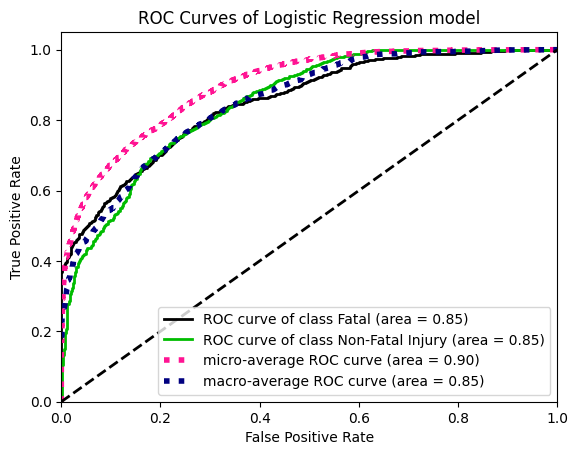

In [10]:
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.title('ROC Curves of Logistic Regression model')
plt.show()

In [11]:
report = classification_report(y_test, y_pred)
print("Classification report of Logistic Regression before tuning model")
print(report)

Classification report of Logistic Regression before tuning model
                  precision    recall  f1-score   support

           Fatal       0.37      0.69      0.48       729
Non-Fatal Injury       0.94      0.81      0.87      4528

        accuracy                           0.79      5257
       macro avg       0.66      0.75      0.68      5257
    weighted avg       0.86      0.79      0.82      5257



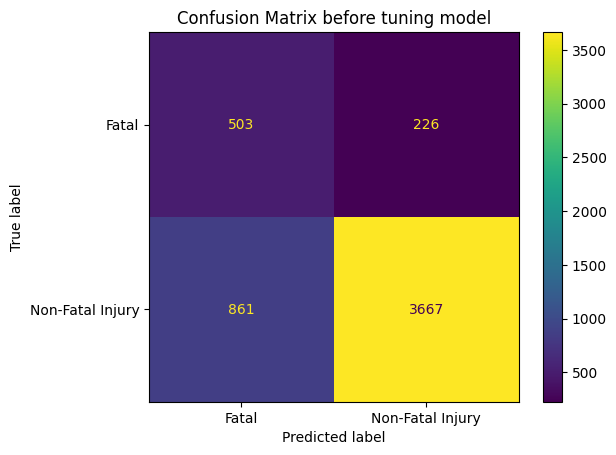

In [12]:
cfs_matrix = confusion_matrix(y_test, y_pred, labels=log_reg.classes_)
display = ConfusionMatrixDisplay(cfs_matrix, display_labels=log_reg.classes_)
display.plot()
plt.title("Confusion Matrix before tuning model")
plt.show()

In [13]:
param_grid = {
    'C': np.logspace(-4, 4, 50),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid = RandomizedSearchCV(log_reg, param_grid, cv=5, n_jobs=-1,
                          scoring='accuracy', n_iter=100, random_state=5)
grid.fit(x_train_prepared, y_train)

print("Best parameters: ", grid.best_params_)
print("Best cross-validation score: ", grid.best_score_)
print("Best estimator: ", grid.best_estimator_)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter 

Best parameters:  {'solver': 'liblinear', 'penalty': 'l1', 'C': 4714.8663634573895}
Best cross-validation score:  0.7931652856226739
Best estimator:  LogisticRegression(C=4714.8663634573895, penalty='l1', random_state=42,
                   solver='liblinear')


In [14]:
log_reg_best = grid.best_estimator_
log_reg_best.fit(x_train_prepared, y_train)
y_pred = log_reg_best.predict(x_test_transformed)
print("Accuracy score on testing data with best parameters: ",
      accuracy_score(y_test, y_pred))

Accuracy score on testing data with best parameters:  0.796271637816245


In [15]:
report = classification_report(y_test, y_pred)
print("Classification report of Logistic Regression after tuning model")
print(report)

Classification report of Logistic Regression after tuning model
                  precision    recall  f1-score   support

           Fatal       0.37      0.69      0.48       729
Non-Fatal Injury       0.94      0.81      0.87      4528

        accuracy                           0.80      5257
       macro avg       0.66      0.75      0.68      5257
    weighted avg       0.86      0.80      0.82      5257



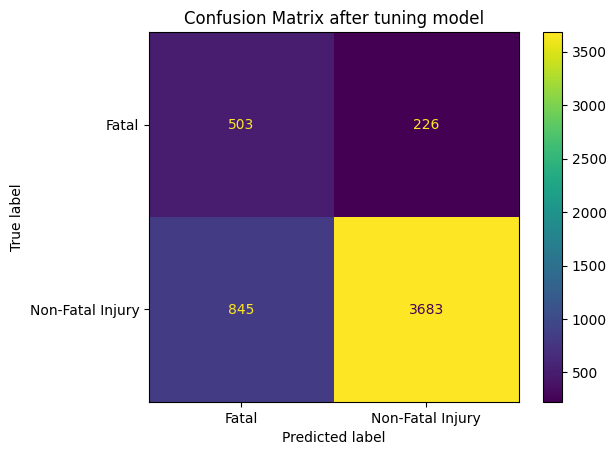

In [16]:
cfs_matrix = confusion_matrix(y_test, y_pred, labels=log_reg.classes_)
display = ConfusionMatrixDisplay(cfs_matrix, display_labels=log_reg.classes_)
display.plot()
plt.title("Confusion Matrix after tuning model")
plt.show()

In [17]:
dump(log_reg_best, '../deployment/log_reg_model.pkl')
dump(full_pipeline, '../deployment/log_reg_pipeline.pkl')

['./deployment/log_reg_pipeline.pkl']